In [1]:
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

2024-10-29 13:37:39.760358: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 13:37:40.004821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 13:37:40.004865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 13:37:40.034863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 13:37:40.097027: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
train_images.shape

(50000, 32, 32, 3)

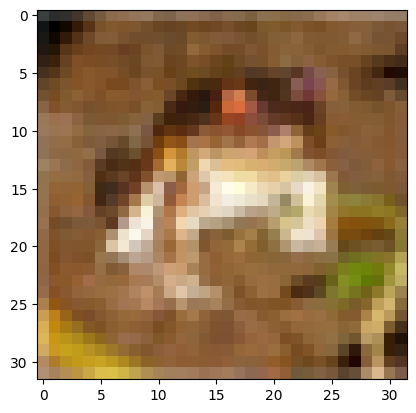

In [5]:
plt.imshow(train_images[0])

In [6]:
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

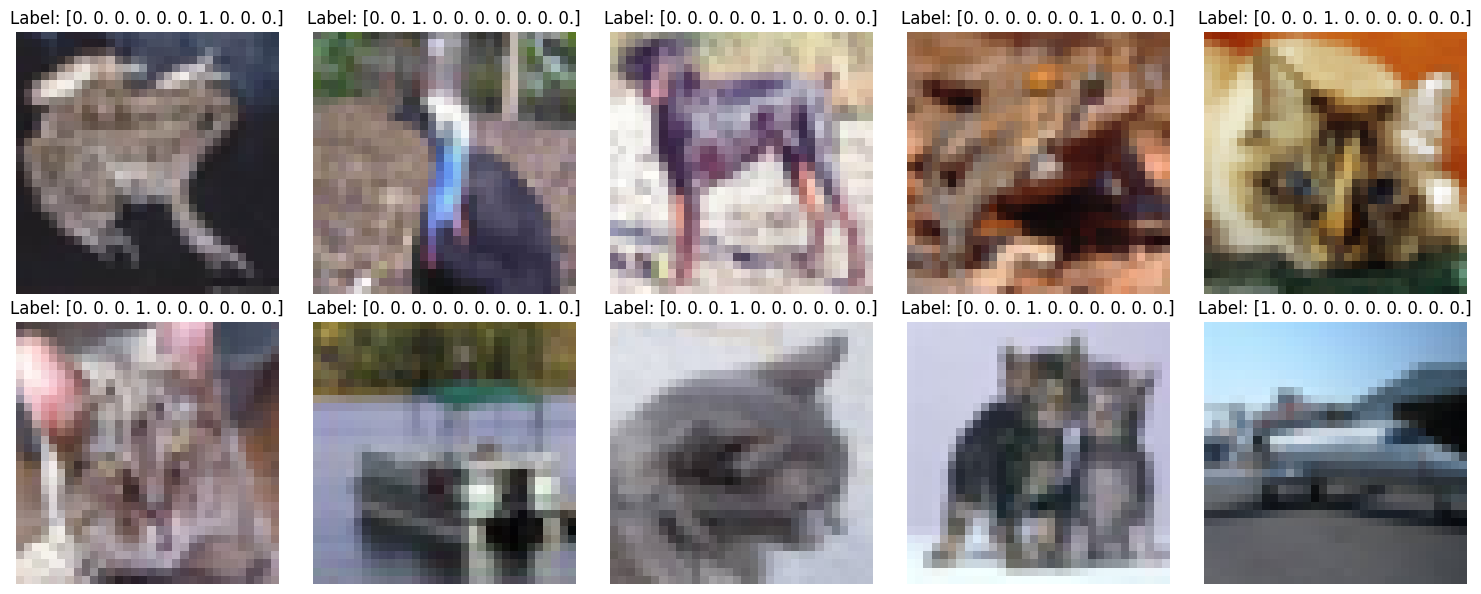

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, lbl, ax in zip(train_images, train_labels, axes):
    ax.imshow(img)
    ax.set_title(f'Label: {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



In [53]:
def residual_block(inputs, filters, stride=1, block_id=1):
    """
    Creates a residual block with two convolutional layers, each with a unique name.

    Args:
        inputs (tensor): Input tensor.
        filters (int): Number of filters for the convolutional layers.
        stride (int): Stride for the first convolutional layer.
        block_id (int): Unique identifier for naming layers.

    Returns:
        tensor: Output tensor after applying the residual block.
    """
    # First Conv2D layer with unique name
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same',
                      kernel_initializer='he_normal',
                      name=f'res_block{block_id}_conv1')(inputs)
    x = layers.BatchNormalization(name=f'res_block{block_id}_bn1')(x)
    x = layers.Activation('relu', name=f'res_block{block_id}_relu1')(x)

    # Second Conv2D layer with unique name
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same',
                      kernel_initializer='he_normal',
                      name=f'res_block{block_id}_conv2')(x)
    x = layers.BatchNormalization(name=f'res_block{block_id}_bn2')(x)

    # Shortcut connection
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same',
                                 kernel_initializer='he_normal',
                                 name=f'res_block{block_id}_conv_shortcut')(inputs)
        shortcut = layers.BatchNormalization(name=f'res_block{block_id}_bn_shortcut')(shortcut)
    else:
        shortcut = inputs

    # Add shortcut and main path
    x = layers.add([x, shortcut], name=f'res_block{block_id}_add')
    x = layers.Activation('relu', name=f'res_block{block_id}_relu2')(x)
    return x


In [73]:
def ResNet20(input_shape=(32, 32, 3), num_classes=10):
    """
    Builds the ResNet20 model with named Conv2D layers.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.

    Returns:
        model: Keras Model instance.
    """
    inputs = layers.Input(shape=input_shape, name='input_layer')

    # Initial convolutional layer
    x = layers.Conv2D(16, (3, 3), strides=1, padding='same',
                      kernel_initializer='he_normal',
                      name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='relu_conv1')(x)

    # Stage 1: 3 Residual Blocks with 16 filters
    for i in range(1, 4):
        x = residual_block(x, filters=16, stride=1, block_id=i)

    # Stage 2: 3 Residual Blocks with 32 filters
    for i in range(4, 7):
        if i == 4:
            # First block in Stage 2 with stride=2
            x = residual_block(x, filters=32, stride=2, block_id=i)
        else:
            x = residual_block(x, filters=32, stride=1, block_id=i)

    # Stage 3: 3 Residual Blocks with 64 filters
    for i in range(7, 10):
        if i == 7:
            # First block in Stage 3 with stride=2
            x = residual_block(x, filters=64, stride=2, block_id=i)
        else:
            x = residual_block(x, filters=64, stride=1, block_id=i)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Fully Connected Layer
    outputs = layers.Dense(num_classes, activation='softmax',
                           kernel_initializer='he_normal',
                           name='fc')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs, name='ResNet20')
    return model


In [74]:
model = ResNet20(input_shape=(32, 32, 3), num_classes=10)

In [75]:
model.summary()

Model: "ResNet20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 16)           448       ['input_layer[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 16)           64        ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 relu_conv1 (Activation)     (None, 32, 32, 16)           0         ['bn_conv1[0][0]']     

In [76]:
def get_flops(model, input_shape):
    # Create a concrete function from the Keras model
    @tf.function
    def model_func(x):
        return model(x)
    
    # Get the concrete function
    concrete_func = model_func.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    
    # Convert variables to constants and get the frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph.as_graph_def()
    
    # Use TensorFlow's profiler
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(frozen_graph, name='')
        run_meta = tf.compat.v1.RunMetadata()
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            )
            return flops.total_float_ops

In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [78]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr = 1e-6, verbose=1)

In [79]:
history = model.fit(train_images, train_labels, epochs=100, batch_size=128, validation_data=(val_images, val_labels), callbacks=[early_stop, reduce_lr])

Epoch 1/100
313/313 [==============================] - 13s 23ms/step - loss: 1.4830 - accuracy: 0.4562 - val_loss: 1.5510 - val_accuracy: 0.4455 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 1.0831 - accuracy: 0.6102 - val_loss: 1.3353 - val_accuracy: 0.5493 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.9005 - accuracy: 0.6792 - val_loss: 1.2093 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.7703 - accuracy: 0.7274 - val_loss: 1.3937 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6776 - accuracy: 0.7609 - val_loss: 1.0108 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 7s 21ms/step - loss: 0.5934 - accuracy: 0.7917 - val_loss: 1.1962 - val_accuracy: 0.6262 - lr: 0.0010
Epoch 7/100
313/313 [==============================] - 7s

In [80]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 1.2054 - accuracy: 0.7722 - 849ms/epoch - 3ms/step


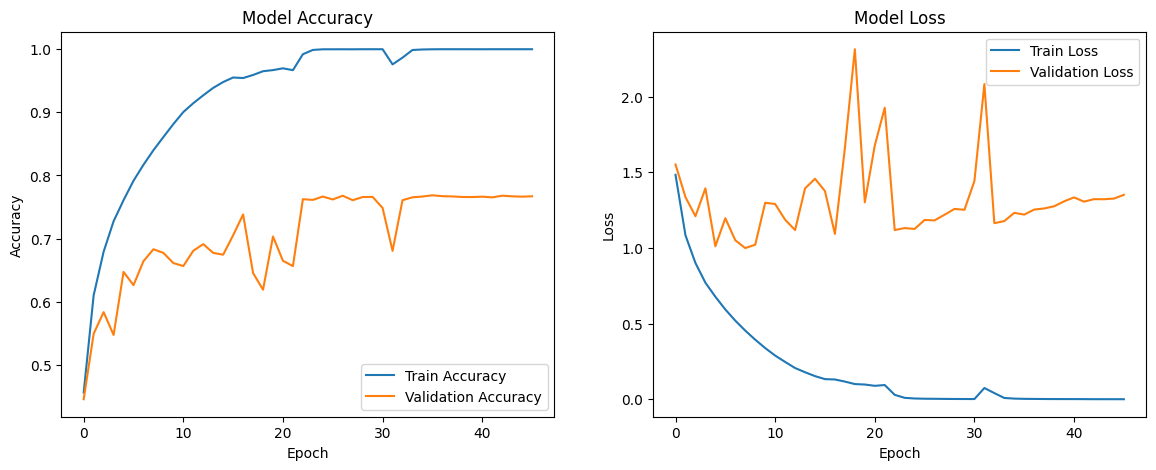

In [81]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [82]:
#for idx, model in enumerate(model_list):
#    model.save(f'model_{idx}.h5')
get_flops(model, train_images.shape)


=========================Options=============================


2024-10-29 14:06:11.224624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 14:06:11.224721: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-10-29 14:06:11.224763: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-10-29 14:06:11.225068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 14:06:11.225155: I external/local_xla/xla/stream_executor/cuda/cuda_e

3276689760000

-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profile:
node name | # float_ops
Conv2D     

In [83]:
def get_conv_layers(model):
    conv_layers = []
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            conv_layers.append(layer)
    return conv_layers

def get_filter_importance(conv_layer):
    weights, biases = conv_layer.get_weights()
    importance = np.sum(np.abs(weights), axis=(0, 1, 2))
    return importance

In [84]:
def determine_pruning_indices(importance, prune_ratio=0.6):
    num_filters = importance.shape[0]
    num_prune = int(num_filters * prune_ratio) 
    prune_indices = np.argsort(importance)[:num_prune]
    return prune_indices.tolist()

In [93]:
def create_pruned_resnet20(original_model, prune_indices_dict):
    """
    Creates a pruned ResNet20 model based on the original model and prune indices.

    Args:
        original_model (tf.keras.Model): The original ResNet20 model.
        prune_indices_dict (dict): Dictionary mapping layer names to filter indices to prune.

    Returns:
        tf.keras.Model: The pruned ResNet20 model.
    """
    inputs = layers.Input(shape=(32, 32, 3), name='input_layer')
    x = inputs

    # Initial Conv Layer
    conv1 = original_model.get_layer('conv1')
    bn_conv1 = original_model.get_layer('bn_conv1')
    relu_conv1 = original_model.get_layer('relu_conv1')

    # Prune conv1
    prune_idx = prune_indices_dict.get('conv1', [])
    keep_idx = [i for i in range(conv1.filters) if i not in prune_idx]
    new_filters = conv1.filters - len(prune_idx)

    # Create new conv1_pruned layer
    x = layers.Conv2D(new_filters, (3,3), strides=1, padding='same',
                      kernel_initializer='he_normal',
                      name='conv1_pruned')(x)
    x = layers.BatchNormalization(name='bn_conv1_pruned')(x)
    x = layers.Activation('relu', name='relu_conv1_pruned')(x)

    # Iterate through residual blocks
    for i in range(1, 10):
        # Prune res_block{i}_conv1
        conv1_name = f'res_block{i}_conv1'
        bn1_name = f'res_block{i}_bn1'
        relu1_name = f'res_block{i}_relu1'
        conv1 = original_model.get_layer(conv1_name)
        prune_idx = prune_indices_dict.get(conv1_name, [])
        keep_idx = [j for j in range(conv1.filters) if j not in prune_idx]
        new_filters = conv1.filters - len(prune_idx)

        x = layers.Conv2D(new_filters, (3,3), strides=conv1.strides, padding='same',
                          kernel_initializer='he_normal',
                          name=f'res_block{i}_conv1_pruned')(x)
        x = layers.BatchNormalization(name=f'res_block{i}_bn1_pruned')(x)
        x = layers.Activation('relu', name=f'res_block{i}_relu1_pruned')(x)

        # Prune res_block{i}_conv2
        conv2_name = f'res_block{i}_conv2'
        bn2_name = f'res_block{i}_bn2'
        conv2 = original_model.get_layer(conv2_name)
        prune_idx = prune_indices_dict.get(conv2_name, [])
        keep_idx_conv2 = [j for j in range(conv2.filters) if j not in prune_idx]
        new_filters_conv2 = conv2.filters - len(prune_idx)

        x = layers.Conv2D(new_filters_conv2, (3,3), strides=1, padding='same',
                          kernel_initializer='he_normal',
                          name=f'res_block{i}_conv2_pruned')(x)
        x = layers.BatchNormalization(name=f'res_block{i}_bn2_pruned')(x)

        # Handle shortcut connection
        shortcut = original_model.get_layer(f'res_block{i}_conv_shortcut', None)
        if shortcut is not None:
            # Prune shortcut conv layer
            prune_idx_shortcut = prune_indices_dict.get(f'res_block{i}_conv_shortcut', [])
            keep_idx_shortcut = [j for j in range(shortcut.filters) if j not in prune_idx_shortcut]
            new_filters_shortcut = shortcut.filters - len(prune_idx_shortcut)

            shortcut_layer = layers.Conv2D(new_filters_shortcut, (1,1), strides=shortcut.strides, padding='same',
                                           kernel_initializer='he_normal',
                                           name=f'res_block{i}_conv_shortcut_pruned')(original_model.get_layer(f'res_block{i}_conv_shortcut').input)
            shortcut_layer = layers.BatchNormalization(name=f'res_block{i}_bn_shortcut_pruned')(shortcut_layer)
        else:
            # Identity shortcut
            shortcut_layer = original_model.get_layer(f'res_block{i}_add').input

        # Add shortcut and main path
        x = layers.add([x, shortcut_layer], name=f'res_block{i}_add_pruned')
        x = layers.Activation('relu', name=f'res_block{i}_relu2_pruned')(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool_pruned')(x)

    # Fully Connected Layer
    x = layers.Dense(num_classes, activation='softmax',
                     kernel_initializer='he_normal',
                     name='fc_pruned')(x)

    # Create the pruned model
    pruned_model = models.Model(inputs=inputs, outputs=x, name='ResNet20_Pruned')
    return pruned_model


In [94]:
def transfer_weights(original_model, pruned_model, prune_indices_dict):
    """
    Transfers weights from the original model to the pruned model.

    Args:
        original_model (tf.keras.Model): The original ResNet20 model.
        pruned_model (tf.keras.Model): The pruned ResNet20 model.
        prune_indices_dict (dict): Dictionary mapping layer names to filter indices to prune.
    """
    for layer in pruned_model.layers:
        if isinstance(layer, layers.Conv2D):
            # Original layer name without '_pruned'
            original_layer_name = layer.name.replace('_pruned', '')
            try:
                original_layer = original_model.get_layer(original_layer_name)
            except ValueError:
                print(f"Original layer {original_layer_name} not found.")
                continue

            # Get original weights
            orig_weights, orig_bias = original_layer.get_weights()
            prune_idx = prune_indices_dict.get(original_layer_name, [])

            # Determine indices to keep
            keep_idx = [i for i in range(orig_weights.shape[-1]) if i not in prune_idx]

            # Prune weights and biases
            new_weights = orig_weights[:, :, :, keep_idx]
            new_bias = orig_bias[keep_idx]

            # Set pruned weights to the new layer
            layer.set_weights([new_weights, new_bias])

        elif isinstance(layer, layers.BatchNormalization):
            # Original layer name without '_pruned'
            original_layer_name = layer.name.replace('_pruned', '')
            try:
                original_layer = original_model.get_layer(original_layer_name)
                layer.set_weights(original_layer.get_weights())
            except ValueError:
                print(f"Original layer {original_layer_name} not found.")
                continue

        elif isinstance(layer, layers.Dense):
            # Original layer name without '_pruned'
            original_layer_name = layer.name.replace('_pruned', '')
            try:
                original_layer = original_model.get_layer(original_layer_name)
                layer.set_weights(original_layer.get_weights())
            except ValueError:
                print(f"Original layer {original_layer_name} not found.")
                continue

    print("Weights transferred successfully.")


In [95]:
def fine_tune_model(pruned_model, x_train, y_train, x_test, y_test):
    """
    Fine-tunes the pruned model on the training data.
    
    Args:
        pruned_model (tf.keras.Model): The pruned ResNet20 model.
        x_train (np.array): Training images.
        y_train (np.array): Training labels.
        x_test (np.array): Test images.
        y_test (np.array): Test labels.
    
    Returns:
        History: Training history.
    """
    # Compile the pruned model
    pruned_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet20_pruned_finetuned.h5', monitor='val_accuracy',
                                 save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                  patience=5, min_lr=1e-6, verbose=1)
    
    # Fine-tune the model
    history = pruned_model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, y_test),
        callbacks=[early_stop, checkpoint, reduce_lr]
    )
    
    return history


In [96]:
conv_layers = get_conv_layers(model)
prune_ratio = 0.5
prune_indices_dict = {}

In [97]:
for conv_layer in conv_layers:
    layer_name = conv_layer.name
    importance = get_filter_importance(conv_layer)
    prune_indices = determine_pruning_indices(importance, prune_ratio)
    prune_indices_dict[layer_name] = prune_indices

In [98]:
prune_indices_dict

{'conv1': [5, 13, 3, 10, 11, 12, 1, 4],
 'res_block1_conv1': [8, 11, 0, 12, 10, 13, 1, 6],
 'res_block1_conv2': [15, 4, 8, 3, 9, 11, 14, 13],
 'res_block2_conv1': [6, 3, 12, 4, 5, 7, 2, 8],
 'res_block2_conv2': [9, 11, 5, 0, 7, 8, 4, 10],
 'res_block3_conv1': [3, 15, 10, 7, 2, 4, 9, 13],
 'res_block3_conv2': [8, 9, 2, 7, 10, 4, 11, 6],
 'res_block4_conv1': [2,
  20,
  18,
  16,
  1,
  0,
  23,
  4,
  27,
  29,
  30,
  6,
  21,
  22,
  15,
  9],
 'res_block4_conv2': [3, 0, 18, 15, 16, 4, 22, 2, 6, 1, 23, 26, 9, 25, 17, 10],
 'res_block4_conv_shortcut': [8,
  26,
  11,
  14,
  19,
  1,
  6,
  23,
  15,
  12,
  31,
  16,
  9,
  18,
  10,
  28],
 'res_block5_conv1': [21,
  13,
  6,
  17,
  26,
  15,
  25,
  16,
  29,
  18,
  8,
  0,
  1,
  5,
  27,
  30],
 'res_block5_conv2': [18,
  7,
  1,
  13,
  12,
  29,
  24,
  22,
  3,
  11,
  17,
  4,
  30,
  19,
  25,
  14],
 'res_block6_conv1': [24,
  16,
  25,
  6,
  0,
  13,
  28,
  10,
  30,
  20,
  2,
  4,
  1,
  5,
  23,
  31],
 'res_block6_c

In [99]:
pruned_model = create_pruned_resnet20(model, prune_indices_dict)

ValueError: No such layer: res_block1_conv_shortcut. Existing layers are: ['input_layer', 'conv1', 'bn_conv1', 'relu_conv1', 'res_block1_conv1', 'res_block1_bn1', 'res_block1_relu1', 'res_block1_conv2', 'res_block1_bn2', 'res_block1_add', 'res_block1_relu2', 'res_block2_conv1', 'res_block2_bn1', 'res_block2_relu1', 'res_block2_conv2', 'res_block2_bn2', 'res_block2_add', 'res_block2_relu2', 'res_block3_conv1', 'res_block3_bn1', 'res_block3_relu1', 'res_block3_conv2', 'res_block3_bn2', 'res_block3_add', 'res_block3_relu2', 'res_block4_conv1', 'res_block4_bn1', 'res_block4_relu1', 'res_block4_conv2', 'res_block4_conv_shortcut', 'res_block4_bn2', 'res_block4_bn_shortcut', 'res_block4_add', 'res_block4_relu2', 'res_block5_conv1', 'res_block5_bn1', 'res_block5_relu1', 'res_block5_conv2', 'res_block5_bn2', 'res_block5_add', 'res_block5_relu2', 'res_block6_conv1', 'res_block6_bn1', 'res_block6_relu1', 'res_block6_conv2', 'res_block6_bn2', 'res_block6_add', 'res_block6_relu2', 'res_block7_conv1', 'res_block7_bn1', 'res_block7_relu1', 'res_block7_conv2', 'res_block7_conv_shortcut', 'res_block7_bn2', 'res_block7_bn_shortcut', 'res_block7_add', 'res_block7_relu2', 'res_block8_conv1', 'res_block8_bn1', 'res_block8_relu1', 'res_block8_conv2', 'res_block8_bn2', 'res_block8_add', 'res_block8_relu2', 'res_block9_conv1', 'res_block9_bn1', 'res_block9_relu1', 'res_block9_conv2', 'res_block9_bn2', 'res_block9_add', 'res_block9_relu2', 'global_avg_pool', 'fc'].

In [100]:
# 2. Define the Residual Block with Named Conv2D Layers
def residual_block(inputs, filters, stride=1, block_id=1):
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same',
                      kernel_initializer='he_normal',
                      name=f'res_block{block_id}_conv1')(inputs)
    x = layers.BatchNormalization(name=f'res_block{block_id}_bn1')(x)
    x = layers.Activation('relu', name=f'res_block{block_id}_relu1')(x)

    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same',
                      kernel_initializer='he_normal',
                      name=f'res_block{block_id}_conv2')(x)
    x = layers.BatchNormalization(name=f'res_block{block_id}_bn2')(x)

    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), strides=stride, padding='same',
                                 kernel_initializer='he_normal',
                                 name=f'res_block{block_id}_conv_shortcut')(inputs)
        shortcut = layers.BatchNormalization(name=f'res_block{block_id}_bn_shortcut')(shortcut)
    else:
        shortcut = inputs

    x = layers.add([x, shortcut], name=f'res_block{block_id}_add')
    x = layers.Activation('relu', name=f'res_block{block_id}_relu2')(x)
    return x

# 3. Build ResNet20 Model with Named Conv2D Layers
def ResNet20(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape, name='input_layer')

    x = layers.Conv2D(16, (3,3), strides=1, padding='same',
                      kernel_initializer='he_normal',
                      name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='relu_conv1')(x)

    # Stage 1: 3 Residual Blocks with 16 filters
    for i in range(1,4):
        x = residual_block(x, filters=16, stride=1, block_id=i)

    # Stage 2: 3 Residual Blocks with 32 filters
    for i in range(4,7):
        if i ==4:
            x = residual_block(x, filters=32, stride=2, block_id=i)
        else:
            x = residual_block(x, filters=32, stride=1, block_id=i)

    # Stage 3: 3 Residual Blocks with 64 filters
    for i in range(7,10):
        if i ==7:
            x = residual_block(x, filters=64, stride=2, block_id=i)
        else:
            x = residual_block(x, filters=64, stride=1, block_id=i)

    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           kernel_initializer='he_normal',
                           name='fc')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='ResNet20')
    return model

# 4. Instantiate and Compile the Original Model
original_model = ResNet20(input_shape=(32,32,3), num_classes=10)
original_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. (Optional) Train the Original Model
# Uncomment to train
history = original_model.fit(
     train_images, train_labels,
     epochs=100,
     batch_size=128,
     validation_data=(val_images, val_labels),
     callbacks=[
         EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
         ModelCheckpoint('resnet20_cifar10.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
         ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
     ]
 )

# 6. Identify Important Filters
def get_conv_layers(model):
    conv_layers = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            conv_layers.append(layer)
    return conv_layers

def get_filter_importance(conv_layer):
    weights, biases = conv_layer.get_weights()
    importance = np.sum(np.abs(weights), axis=(0,1,2))  # Sum over height, width, input channels
    return importance

def determine_pruning_indices(importance, prune_ratio=0.1):
    num_filters = importance.shape[0]
    num_prune = int(num_filters * prune_ratio)
    prune_indices = np.argsort(importance)[:num_prune]
    return prune_indices.tolist()

conv_layers = get_conv_layers(original_model)
prune_ratio = 0.1  # Prune 10% of filters in each Conv2D layer
prune_indices_dict = {}

for conv_layer in conv_layers:
    layer_name = conv_layer.name
    importance = get_filter_importance(conv_layer)
    prune_indices = determine_pruning_indices(importance, prune_ratio)
    prune_indices_dict[layer_name] = prune_indices
    print(f"Pruning {len(prune_indices)} filters from layer {layer_name}")

# 7. Create a Pruned ResNet20 Model
pruned_model = create_pruned_resnet20(original_model, prune_indices_dict)

# 8. Transfer Weights to the Pruned Model
transfer_weights(original_model, pruned_model, prune_indices_dict)

# 9. Fine-Tune the Pruned Model
# Compile the pruned model
pruned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet20_pruned_finetuned.h5', monitor='val_accuracy',
                             save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1)

# Fine-tune the model
history_pruned = pruned_model.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=128,
    validation_data=(val_images, val_labels),
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# 10. Evaluate the Pruned Model
test_loss, test_accuracy = pruned_model.evaluate(test_images, test_labels, verbose=2)
print(f"\nPruned Model Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 1.5136 - accuracy: 0.4484
Epoch 1: val_accuracy improved from -inf to 0.45510, saving model to resnet20_cifar10.h5
313/313 [==============================] - 13s 23ms/step - loss: 1.5136 - accuracy: 0.4484 - val_loss: 1.5410 - val_accuracy: 0.4551 - lr: 0.0010
Epoch 2/100
  4/313 [..............................] - ETA: 6s - loss: 1.1622 - accuracy: 0.5645

/home/am/Documents/VirtualEnv/tensorflow-gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 1.1052 - accuracy: 0.6022
Epoch 2: val_accuracy improved from 0.45510 to 0.55150, saving model to resnet20_cifar10.h5
313/313 [==============================] - 7s 22ms/step - loss: 1.1052 - accuracy: 0.6022 - val_loss: 1.2561 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.6798
Epoch 3: val_accuracy improved from 0.55150 to 0.58310, saving model to resnet20_cifar10.h5
313/313 [==============================] - 7s 22ms/step - loss: 0.8996 - accuracy: 0.6798 - val_loss: 1.2094 - val_accuracy: 0.5831 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 0.7591 - accuracy: 0.7303
Epoch 4: val_accuracy improved from 0.58310 to 0.60280, saving model to resnet20_cifar10.h5
313/313 [==============================] - 7s 22ms/step - loss: 0.7591 - accuracy: 0.7303 - val_loss: 1.2275 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 5/10

ValueError: No such layer: res_block1_conv_shortcut. Existing layers are: ['input_layer', 'conv1', 'bn_conv1', 'relu_conv1', 'res_block1_conv1', 'res_block1_bn1', 'res_block1_relu1', 'res_block1_conv2', 'res_block1_bn2', 'res_block1_add', 'res_block1_relu2', 'res_block2_conv1', 'res_block2_bn1', 'res_block2_relu1', 'res_block2_conv2', 'res_block2_bn2', 'res_block2_add', 'res_block2_relu2', 'res_block3_conv1', 'res_block3_bn1', 'res_block3_relu1', 'res_block3_conv2', 'res_block3_bn2', 'res_block3_add', 'res_block3_relu2', 'res_block4_conv1', 'res_block4_bn1', 'res_block4_relu1', 'res_block4_conv2', 'res_block4_conv_shortcut', 'res_block4_bn2', 'res_block4_bn_shortcut', 'res_block4_add', 'res_block4_relu2', 'res_block5_conv1', 'res_block5_bn1', 'res_block5_relu1', 'res_block5_conv2', 'res_block5_bn2', 'res_block5_add', 'res_block5_relu2', 'res_block6_conv1', 'res_block6_bn1', 'res_block6_relu1', 'res_block6_conv2', 'res_block6_bn2', 'res_block6_add', 'res_block6_relu2', 'res_block7_conv1', 'res_block7_bn1', 'res_block7_relu1', 'res_block7_conv2', 'res_block7_conv_shortcut', 'res_block7_bn2', 'res_block7_bn_shortcut', 'res_block7_add', 'res_block7_relu2', 'res_block8_conv1', 'res_block8_bn1', 'res_block8_relu1', 'res_block8_conv2', 'res_block8_bn2', 'res_block8_add', 'res_block8_relu2', 'res_block9_conv1', 'res_block9_bn1', 'res_block9_relu1', 'res_block9_conv2', 'res_block9_bn2', 'res_block9_add', 'res_block9_relu2', 'global_avg_pool', 'fc'].